Comparing artificial background samples from CATHODE, CURTAINS, FETA, and SALAD to each other and to an actually simulated background. 

Taken from Slack (original text for CATHODE, CURTAINS, FETA):

```
Each subfolder nsig_injected_x contains 4 .npy files. 1 is the corresponding "LHC" (Pythia) data with x injected signal events, and the other 3 are the synthetic samples generated from the LHC data (and "simulated" (Herwig) data for FETA). All of these are signal region events, with m_jj between 3.3 and 3.7 TeV.
There are also files STS_sig.npy and STS_bkg.npy corresponding to 20,000 signal and 20,000 background dijet events. These events make up the "Standard Test Set" and were not used at all during training.
The .npy files have dimensions of (num_events, 6). The second index corresponds to the features (mj1, delta mj, tau21_j1, tau21_d2, deltaR, m_jj). All features have been mixmaxscaled to the range (0, 1). The exception is the m_jj feature, which has been scaled to the range (0.33, 0.67). This corresponds to scaling the mass band (3.1, 3.9) TeV (which corresponds to SB1, SR, SB2) to the range (0,1).

old data (with flat m_JJ distribution in CATHODE):
https://berkeley.box.com/s/rsbqw1fasqc5ykqah40mnd4hkhiyc90r

new data (with correct m_JJ distribution):
https://berkeley.box.com/s/y7835rnlw6chno3d4tz2mrxhsxo8sjgx
```

New data, including SALAD:

```
https://berkeley.box.com/s/hggnrqh83zaojeskdmm3zfi2apk1aeta
```


Idea of the study: 

train a multiclass classifier on CATHODE vs CURTAINS vs FETA vs SALAD
----------------------------------------------------------------------------------------------------------

- do it balanced, with the number of samples given by the smallest set of samples (will be CATHODE, 400k total)
- do it with all available samples, using class weights

- do it with the same NN as the rest of the paper
- do it with a bigger NN as the rest of the paper

- look at log posterior 

In [1]:
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt
import mpltern # https://mpltern.readthedocs.io/en/latest/installation.html
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

torch.set_default_dtype(torch.float64)

plt.style.use("science.mplstyle")
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath} \usepackage{amssymb}'

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [2]:
# loading and understanding the data
data_path = '/home/claudius/ML_source/bkg_ccf/data_for_final_analysis/scaled_data_wide/'

cathode_data = np.load(f"{data_path}nsig_injected_0/cathode.npy")
curtains_data = np.load(f"{data_path}nsig_injected_0/curtains.npy")
feta_data = np.load(f"{data_path}nsig_injected_0/feta_o6.npy")
salad_data = np.load(f"{data_path}nsig_injected_0/salad.npy")
salad_weights = np.load(f"{data_path}nsig_injected_0/salad_weights.npy")

truth_data = np.load(f"{data_path}nsig_injected_0/data.npy")


print("data contains: mj1, delta mj, tau21_j1, tau21_d2, deltaR, m_jj")
for data in [cathode_data, curtains_data, feta_data, salad_data, truth_data]:
    print("shape: ", data.shape)
    print("min: ", data.min(axis=0))
    print("mean: ", data.mean(axis=0))
    print("max: ", data.max(axis=0))

data contains: mj1, delta mj, tau21_j1, tau21_d2, deltaR, m_jj
shape:  (400000, 6)
min:  [ 4.94362693e-03  1.90454969e-07  2.29636542e-02 -1.57495635e-03
  2.00533226e-01  4.50000000e-01]
mean:  [0.13518009 0.12043567 0.57921261 0.4824966  0.55880448 0.49511516]
max:  [0.84141445 0.73663813 0.9893744  1.00536549 0.85372049 0.55      ]
shape:  (1866816, 6)
min:  [ 2.77189794e-03  6.36700002e-16  1.53287807e-02 -1.46005545e-02
  1.96302757e-01  4.49882358e-01]
mean:  [0.13403158 0.12060626 0.57994329 0.48253784 0.55669686 0.49518479]
max:  [0.94141889 0.88695806 0.99113005 1.01191103 0.92550874 0.54990494]
shape:  (731868, 6)
min:  [-0.26088436 -0.33336361 -0.37281863 -0.4324499  -0.36947759  0.4498837 ]
mean:  [0.13462199 0.12114861 0.58171537 0.48369635 0.5593914  0.49501906]
max:  [1.3124152  1.35115918 1.32156165 1.26961946 1.31514621 0.5499076 ]
shape:  (1044782, 6)
min:  [ 0.00126073  0.          0.00679913 -0.00465461  0.16702601  0.44988187]
mean:  [0.1285373  0.12729118 0.544848

Looking at these numbers, we see that we can train a **balanced** multiclass classifier of CATHODE vs CURTAINS vs FETA vs SALAD  using 400k events of each method. We evaluate on the 120k truth events in the end. 

For training, a train / test / val split of 60/20/20 would mean 240k train, 80k test, and 80k val events. 

Before training the classifier, let's have a look at a few histograms in physical space.

In [3]:
# from https://github.com/rmastand/FETA/blob/ee4942e668b94df7b504b1503b027bdc28827eb1/helpers/datasets.py#L227

# standardization transformation and its inverse:
def minmaxscale(data, col_minmax, lower = -3.0, upper = 3.0, forward = True):
    if forward:    
        minmaxscaled_data = np.zeros(data.shape)
        for col in range(data.shape[1]):
            X_std = (data[:, col] - col_minmax[col][0]) / (col_minmax[col][1] - col_minmax[col][0])
            minmaxscaled_data[:, col] = X_std * (upper - lower) + lower      
        return minmaxscaled_data

    else:  
        reversescaled_data = np.zeros(data.shape)
        for col in range(data.shape[1]):
            X_std = (data[:, col] - lower) / (upper - lower)
            reversescaled_data[:, col] = X_std * (col_minmax[col][1] - col_minmax[col][0]) + col_minmax[col][0]
        return reversescaled_data
    
colors_dict = {"truth":"grey",
               "salad": "#009E73",
               "feta": "#CC79A7",
               "cathode":"#D55E00",
               "curtains":"#E69F00"}

In [4]:
# load minmax and transform data to physical space

col_minmax = np.load(f"{data_path}col_minmax.npy")
cathode_physical = minmaxscale(cathode_data, col_minmax, lower=0, upper=1, forward=False)
curtains_physical = minmaxscale(curtains_data, col_minmax, lower=0, upper=1, forward=False)
feta_physical = minmaxscale(feta_data, col_minmax, lower=0, upper=1, forward=False)
salad_physical = minmaxscale(salad_data, col_minmax, lower=0, upper=1, forward=False)
truth_physical = minmaxscale(truth_data, col_minmax, lower=0, upper=1, forward=False)

luatex: /home/claudius/miniconda3/envs/tf-madnis/lib/libcurl.so.4: no version information available (required by /usr/bin/../lib/../lib/libmiktex-packagemanager.so.10)


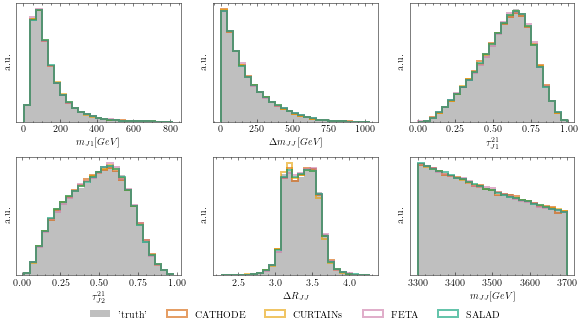

In [5]:
# plot them in comparison to see if transformation etc. worked correctly
plt.figure(figsize=(10,5))

title_dict = {0: f"$m_{{J1}} [GeV]$", 1: f"$\Delta m_{{JJ}} [GeV]$", 2: f"$\\tau_{{J1}}^{{21}}$", 
              3: f"$\\tau_{{J2}}^{{21}}$", 4: f"$\Delta R_{{JJ}}$", 5: f"$m_{{JJ}} [GeV]$"}
kwargs = {'density': True, 'histtype': 'step', 'lw': 2., 'alpha': 0.6}
legend_loc = ['upper right', 'upper right', 'upper left', 'upper left', 'upper left', 'lower left']
for i in range(6): #loop over 6 features
    plt.subplot(2,3,i+1)
    _, bins, _ = plt.hist(truth_physical[:, i], bins=25, histtype='stepfilled', alpha=0.5, label=f"'truth'", density=True,color=colors_dict['truth'])
    _ = plt.hist(cathode_physical[:, i], bins=bins, label='CATHODE', color=colors_dict['cathode'], **kwargs)
    _ = plt.hist(curtains_physical[:, i], bins=bins, label='CURTAINs',color=colors_dict['curtains'], **kwargs)
    _ = plt.hist(feta_physical[:, i], bins=bins, label='FETA',color=colors_dict['feta'], **kwargs)
    _ = plt.hist(salad_physical[:, i], bins=bins, label='SALAD', weights=salad_weights,color=colors_dict['salad'], **kwargs)
    plt.xlabel(title_dict[i])
    plt.gca().get_yaxis().set_ticks([])
    plt.ylabel('a.u.')
    
plt.subplot(2,3,5)
plt.legend(loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.45))
plt.subplots_adjust(wspace=0.2, hspace=0.3)
plt.savefig(f'background_validation.pdf', facecolor='white')
plt.show()

The distributions seem to agree with fig. 4 of FETA (2212.11285).

In [6]:
# taken from https://github.com/rmastand/synthetic_SM_AD/blob/main/helpers/nn.py on July 7th
# and adapted
class NeuralNet(nn.Module):
    def __init__(self, input_shape):
        super(NeuralNet, self).__init__()

        # Designed to ensure that adjacent pixels are either all 0s or all active
        # with an input probability
        #self.dropout1 = nn.Dropout2d(0.1)
        #self.dropout2 = nn.Dropout2d(0.1)

        # First fully connected layer
        self.fc1 = nn.Linear(input_shape, 64) # first size is output of flatten
        # Second fully connected layer that outputs our labels
        self.fc2 = nn.Linear(64, 32)

        # output changed from 1 to 4 for multiclass test
        self.fc3 = nn.Linear(32, 4)

        
    # x represents our data
    def forward(self, x):

        x = torch.flatten(x, 1)
        # Pass data through fc1
        x = F.relu(self.fc1(x))
        #x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        #x = self.dropout2(x)
        x = self.fc3(x)
    
        # Apply softmax to x, so NLLLoss can be used
        output = F.log_softmax(x, dim=1)
        #output = torch.sigmoid(x) # for BCE 
        
        return output
    
class MyNeuralNet(nn.Module):
    def __init__(self, input_shape):
        super(MyNeuralNet, self).__init__()

        # Designed to ensure that adjacent pixels are either all 0s or all active
        # with an input probability
        self.dropout1 = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout(0.1)
        self.dropout3 = nn.Dropout(0.1)

        # First fully connected layer
        self.fc1 = nn.Linear(input_shape, 128) # first size is output of flatten
        # Second fully connected layer that outputs our labels
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 64)

        # output changed from 1 to 4 for multiclass test
        self.fc4 = nn.Linear(64, 4)

        
    # x represents our data
    def forward(self, x):

        x = torch.flatten(x, 1)
        # Pass data through fc1
        x = F.leaky_relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.leaky_relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.leaky_relu(self.fc3(x))
        x = self.dropout3(x)
        x = self.fc4(x)
    
        # Apply softmax to x, so NLLLoss can be used
        output = F.log_softmax(x, dim=1)
        #output = torch.sigmoid(x) # for BCE 
        
        return output

# balanced data

In [7]:
# data preparation:
# select same number of events from datasets
# append weight for salad, 1 for the rest
# append label (cathode:0, curtains:1, feta: 2, salad: 3)
# split train/test/val
# make dataset

np.random.seed(2104)

sample_size = 400_000
batch_size = 2_000

cathode_indices = np.random.choice(np.arange(len(cathode_data)), size=sample_size, replace=False)
cathode_data_cut = cathode_data[cathode_indices]
cathode_data_cut = np.concatenate((cathode_data_cut, np.ones((sample_size,1)),0.*np.ones((sample_size,1))), axis=1)

curtains_indices = np.random.choice(np.arange(len(curtains_data)), size=sample_size, replace=False)
curtains_data_cut = curtains_data[curtains_indices]
curtains_data_cut = np.concatenate((curtains_data_cut, np.ones((sample_size,1)), 1.*np.ones((sample_size,1))), axis=1)

feta_indices = np.random.choice(np.arange(len(feta_data)), size=sample_size, replace=False)
feta_data_cut = feta_data[feta_indices]
feta_data_cut = np.concatenate((feta_data_cut, np.ones((sample_size,1)), 2.*np.ones((sample_size,1))), axis=1)

salad_indices = np.random.choice(np.arange(len(salad_data)), size=sample_size, replace=False)
salad_data_cut = salad_data[salad_indices]
salad_data_cut = np.concatenate((salad_data_cut, salad_weights[salad_indices].reshape(sample_size,1), 3.*np.ones((sample_size,1))), axis=1)

truth_data_cut = np.concatenate((truth_data, 4.*np.ones((truth_data.shape[0], 1))), axis=1)

split_indices = [int(0.6*sample_size), int(0.2*sample_size), int(0.2*sample_size)]
assert np.sum(split_indices) == sample_size
split_indices = np.cumsum(split_indices)
print("Train / Test / Val split at indices ", split_indices)

train_cathode, test_cathode, val_cathode = np.split(cathode_data_cut, split_indices[:2])
train_curtains, test_curtains, val_curtains = np.split(curtains_data_cut, split_indices[:2])
train_feta, test_feta, val_feta = np.split(feta_data_cut, split_indices[:2])
train_salad, test_salad, val_salad = np.split(salad_data_cut, split_indices[:2])


train_data = np.concatenate((train_cathode, train_curtains, train_feta, train_salad))
test_data = np.concatenate((test_cathode, test_curtains, test_feta, test_salad))
val_data = np.concatenate((val_cathode, val_curtains, val_feta, val_salad))

train_dataset = TensorDataset(torch.tensor(train_data).to(device))
test_dataset = TensorDataset(torch.tensor(test_data).to(device))
val_dataset = TensorDataset(torch.tensor(val_data).to(device))
truth_dataset = TensorDataset(torch.tensor(truth_data_cut).to(device))

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
truth_dataloader = DataLoader(truth_dataset, batch_size=1000, shuffle=False)

Train / Test / Val split at indices  [240000 320000 400000]


In [8]:
# Kish's effective sample size = (sum weights)**2 / sum (weights**2) => too large class weight, salad will dominate
# induced sample size: sum weights. 

for sample in [train_salad, test_salad, val_salad]:
    sum_of_square = (sample[:, 6]**2).sum()
    square_of_sum = sample[:, 6].sum()**2
    print("size of sample", sample.shape[0])
    print("sum of (weight**2)", sum_of_square)
    print("square of (weights.sum)", square_of_sum)
    print("((sum w)**2 / (sum w**2), which is Kish's effective sample size", (square_of_sum/sum_of_square))
    print("ratio of size to ((sum w)**2 / (sum w**2)", sample.shape[0] / (square_of_sum/sum_of_square))
    print("sum of |weights| and n/sum|weights|: ", sample[:, 6].sum(), sample.shape[0]/sample[:, 6].sum())
    print(" * * * ")

# will use 1.021 for the subsequent analysis

size of sample 240000
sum of (weight**2) 259169.82232012894
square of (weights.sum) 55248487647.33989
((sum w)**2 / (sum w**2), which is Kish's effective sample size 213174.8486484528
ratio of size to ((sum w)**2 / (sum w**2) 1.1258363804249
sum of |weights| and n/sum|weights|:  235049.96840531565 1.021059486322281
 * * * 
size of sample 80000
sum of (weight**2) 86234.89506996352
square of (weights.sum) 6130749572.45207
((sum w)**2 / (sum w**2), which is Kish's effective sample size 71093.60505950765
ratio of size to ((sum w)**2 / (sum w**2) 1.1252770194033261
sum of |weights| and n/sum|weights|:  78299.10326722823 1.021723067848769
 * * * 
size of sample 80000
sum of (weight**2) 86402.38343867272
square of (weights.sum) 6137247501.907438
((sum w)**2 / (sum w**2), which is Kish's effective sample size 71030.99773009821
ratio of size to ((sum w)**2 / (sum w**2) 1.1262688482003587
sum of |weights| and n/sum|weights|:  78340.58655580413 1.0211820400784697
 * * * 


In [9]:
def find_accuracy(pred, label, individual=False):
    overall = (np.argmax(pred, axis=-1) == label).astype(float) #.mean()
    if individual:
        cathode = (np.argmax(pred[label==0], axis=-1) == 0).astype(float)
        curtains = (np.argmax(pred[label==1], axis=-1) == 1).astype(float)
        feta = (np.argmax(pred[label==2], axis=-1) == 2).astype(float)
        salad = (np.argmax(pred[label==3], axis=-1) == 3).astype(float)
        return overall, (cathode, curtains, feta, salad)
    else:
        return overall

def train(model, dataloader, optimizer, criterion):
    model.train()
    train_loss = []
    train_weights = []
    for i, batch in enumerate(dataloader):
        optimizer.zero_grad()
            
        batch_data = batch[0][:, :5]
        batch_weight = batch[0][:, 6]
        batch_labels = batch[0][:, -1].to(torch.long)
            
        loss = batch_weight*criterion(model(batch_data), batch_labels)
        train_loss.append(loss.tolist())
        train_weights.append(batch_weight.tolist())
        
        #loss = loss.sum()/batch_weight.sum()
        loss = loss.mean()
        
        loss.backward()
        optimizer.step()
        if i % 40 == 0:
            print(f"step {i:4d} / {len(dataloader)}; loss {loss.item():.4f}")
    train_loss = np.array(train_loss).flatten()
    train_weights = np.array(train_weights).flatten()
    #return train_loss.sum()/train_weights.sum()
    return train_loss.mean()

@torch.no_grad()
def evaluate(model, dataloader, criterion):
    model.eval()
    eval_loss = []
    eval_weights = []
    acc = []
    acc_individual = {'cathode': [], 'curtains': [], 'feta': [], 'salad': []}
    for batch in dataloader:            
        batch_data = batch[0][:, :5]
        batch_weight = batch[0][:, 6]
        batch_labels = batch[0][:, -1].to(torch.long)
            
        loss = batch_weight*criterion(pred:=model(batch_data), batch_labels)
        eval_loss.append(loss.tolist())
        eval_weights.append(batch_weight.tolist())
        local_acc, local_acc_individual = find_accuracy(np.exp(pred.cpu().numpy()), batch_labels.cpu().numpy(), individual=True)
        acc.append(local_acc)
        acc_individual['cathode'].append(local_acc_individual[0])
        acc_individual['curtains'].append(local_acc_individual[1])
        acc_individual['feta'].append(local_acc_individual[2])
        acc_individual['salad'].append(local_acc_individual[3])
    eval_loss = np.array(eval_loss).flatten()
    eval_weights = np.array(eval_weights).flatten()
    acc = np.array(acc).flatten()
    for key in acc_individual:
        acc_individual[key] = np.concatenate([*acc_individual[key]]).flatten()
    #print(f"Evaluation loss {eval_loss.sum()/eval_weights.sum()}, accuracy {acc.mean()}, acc CATHODE: {acc_individual['cathode'].mean():.3f}, acc CURTAINS: {acc_individual['curtains'].mean():.3f}, acc FETA: {acc_individual['feta'].mean():.3f}, acc SALAD: {acc_individual['salad'].mean():.3f}")
    #return eval_loss.sum()/eval_weights.sum(), acc
    print(f"Evaluation loss {eval_loss.mean()}, accuracy {acc.mean()}, acc CATHODE: {acc_individual['cathode'].mean():.3f}, acc CURTAINS: {acc_individual['curtains'].mean():.3f}, acc FETA: {acc_individual['feta'].mean():.3f}, acc SALAD: {acc_individual['salad'].mean():.3f}")
    return eval_loss.mean(), acc

@torch.no_grad()
def get_prediction(model, dataloader):
    model.eval()
    preds = []
    weights = []
    for batch in dataloader:            
        batch_data = batch[0][:, :5]
        weights.append(np.array(batch[0][:, 6].tolist()))
        batch_labels = batch[0][:, -1]
        batch_preds = np.array(model(batch_data).tolist())
        
        preds.append(np.concatenate((batch_preds, batch_labels.reshape(-1, 1).tolist()), axis=1))
    weights = np.concatenate([*weights])
    preds = np.concatenate([*preds])
    preds[:, :4] = np.exp(preds[:, :4])
    return preds, weights

def save_weights(model, appendix=None):
    """ saves the model to file """
    if appendix is not None:
        file_name = f'multiclass_weights_{appendix}.pt'
    else:
        file_name = f'multiclass_weights.pt'
    torch.save({'model_state_dict': model.state_dict()}, file_name)
    print("Model saved")

def load_weights(model, device, appendix=None):
    """ loads the model from file """
    if appendix is not None:
        file_name = f'multiclass_weights_{appendix}.pt'
    else:
        file_name = f'multiclass_weights.pt'
    checkpoint = torch.load(file_name, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    print(f"Model {file_name} loaded")
    
def log_posterior(preds, weights=None):
    """ log posterior scores = sum_{x in geant} log p(C|x) where C = CATHODE, CURTAINS, FETA, SALAD """
    if weights is None:
        return np.log(preds).sum(axis=0)
    else:
        return (weights*np.log(preds)).sum(axis=0)


## original NN

In [10]:
# build NN and optimizer, following https://github.com/rmastand/FETA/blob/ee4942e668b94df7b504b1503b027bdc28827eb1/helpers/evaluation.py#L209

dense_net = NeuralNet(input_shape=5)
dense_net.to(device)

print("model architecture ")
print(dense_net)
total_parameters = sum(p.numel() for p in dense_net.parameters() if p.requires_grad)
print(f"Model has {total_parameters:d} trainable parameters")

criterion = nn.NLLLoss(reduction='none', weight=torch.tensor([1., 1., 1., 1.021]).to(device)) #, weight=torch.tensor([1., 1., 1., 9./8.]).to(device)
optimizer = torch.optim.Adam(dense_net.parameters(), lr=1e-3)

model architecture 
NeuralNet(
  (fc1): Linear(in_features=5, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=4, bias=True)
)
Model has 2596 trainable parameters


In [ ]:
num_epoch = 400
name_appendix = 'run09_balanced_original_5_classwgt_1.021'

best_val_loss = 1e6

accuracy = []
_, acc = evaluate(dense_net, test_dataloader, criterion)
accuracy.append(acc.mean())

train_losses = []
eval_losses = []

for epoch in range(num_epoch):
    print(f"Epoch {epoch+1} / {num_epoch}")
    train_loss = train(dense_net, train_dataloader, optimizer, criterion)
    eval_loss, acc = evaluate(dense_net, test_dataloader, criterion)
    train_losses.append(train_loss.mean())
    eval_losses.append(eval_loss)
    accuracy.append(acc.mean())
    if eval_loss.mean() < best_val_loss:
        save_weights(dense_net, appendix=name_appendix)
        best_val_loss = eval_loss.mean()
    print("   - - - - -   ")

load_weights(dense_net, device, appendix=name_appendix)
_ = evaluate(dense_net, test_dataloader, criterion)

Evaluation loss 1.391887272547223, accuracy 0.25008125, acc CATHODE: 1.000, acc CURTAINS: 0.000, acc FETA: 0.000, acc SALAD: 0.000
Epoch 1 / 400
step    0 / 480; loss 1.3769
step   40 / 480; loss 1.3900
step   80 / 480; loss 1.3804
step  120 / 480; loss 1.3905
step  160 / 480; loss 1.3831
step  200 / 480; loss 1.3900
step  240 / 480; loss 1.3835


In [ ]:
epochs = np.arange(num_epoch) + 1
plt.plot(epochs, train_losses, label='train')
plt.plot(epochs, eval_losses, label='test')
plt.legend()
#plt.ylim(1.375, 1.38)
plt.ylim(1.383, 1.386)
plt.show()

plt.plot(accuracy)
plt.ylabel("Accuracy")
plt.show()

In [13]:
# test eval, not needed for full run
name_appendix = 'run01_balanced_original'
load_weights(dense_net, device, appendix=name_appendix)
_ = evaluate(dense_net, test_dataloader, criterion)

Model multiclass_weights_run01_balanced_original.pt loaded
Evaluation loss 1.377166776743359, accuracy 0.259675, acc CATHODE: 0.286, acc CURTAINS: 0.334, acc FETA: 0.362, acc SALAD: 0.057


In [14]:
# test eval, not needed for full run
name_appendix = 'run01_balanced_original'
load_weights(dense_net, device, appendix=name_appendix)
preds_models, weights_models = get_prediction(dense_net, test_dataloader)
preds_truth, _ = get_prediction(dense_net, truth_dataloader)

Model multiclass_weights_run01_balanced_original.pt loaded


In [15]:
# test eval, not needed for full run
preds_cathode = preds_models[preds_models[:, -1] == 0.][:, :4]
preds_curtains = preds_models[preds_models[:, -1] == 1.][:, :4]
preds_feta = preds_models[preds_models[:, -1] == 2.][:, :4]
preds_salad = preds_models[preds_models[:, -1] == 3.][:, :4]
weights_salad = weights_models[preds_models[:, -1] == 3.]
preds_truth = preds_truth[:, :4]

In [16]:
# test eval, not needed for full run
output_str = "Accuracy of {} is {:.4f}"
print(output_str.format("CATHODE", find_accuracy(preds_cathode, 0.).mean()))
print(output_str.format("CURTAINS", find_accuracy(preds_curtains, 1.).mean()))
print(output_str.format("FETA", find_accuracy(preds_feta, 2.).mean()))
#print(output_str.format("SALAD", (weights_salad*find_accuracy(preds_salad, 3.)).sum()/weights_salad.sum()))
print(output_str.format("SALAD", (weights_salad*find_accuracy(preds_salad, 3.)).mean()))

Accuracy of CATHODE is 0.2860
Accuracy of CURTAINS is 0.3339
Accuracy of FETA is 0.3622
Accuracy of SALAD is 0.0590


In [12]:
# run multiple runs at once: compute log posterior

output_str = "log posterior of {} is {}. Argmax is at {}"
output_str_2 = "log posterior of {} is {} +/- {}. Argmax is at {}"

preds_cathode_list = []
preds_curtains_list = []
preds_feta_list = []
preds_salad_list = []
weights_salad_list = []
preds_truth_list = []

log_posterior_dict = {'CATHODE': [], 'CURTAINS': [], 'FETA': [], 'SALAD': [], 'TRUTH': []}

for run_nr in [1,2,3,4,5,6,7,8]: #, 2, 3, 4, 5, 6, 7, 8, 9, 10
    print(f"Run nr {run_nr}")
    name_appendix = f'run{run_nr:02d}_balanced_original_5_classwgt_1.021'
    load_weights(dense_net, device, appendix=name_appendix)
    preds_models, weights_models = get_prediction(dense_net, test_dataloader)
    preds_truth, _ = get_prediction(dense_net, truth_dataloader)
    preds_cathode_list.append(preds_models[preds_models[:, -1] == 0.][:, :4])
    preds_curtains_list.append(preds_models[preds_models[:, -1] == 1.][:, :4])
    preds_feta_list.append(preds_models[preds_models[:, -1] == 2.][:, :4])
    preds_salad_list.append(preds_models[preds_models[:, -1] == 3.][:, :4])
    weights_salad_list.append(weights_models[preds_models[:, -1] == 3.].reshape(-1,1))
    preds_truth_list.append(preds_truth[:, :4])
    
    print(output_str.format("CATHODE samples", 
                            post_local:=log_posterior(preds_cathode_list[-1]), 
                            np.argmax(log_posterior(preds_cathode_list[-1]))))
    log_posterior_dict['CATHODE'].append(post_local/len(preds_cathode_list[-1]))
    print(output_str.format("CURTAINS samples", 
                            post_local:=log_posterior(preds_curtains_list[-1]), 
                            np.argmax(log_posterior(preds_curtains_list[-1]))))
    log_posterior_dict['CURTAINS'].append(post_local/len(preds_curtains_list[-1]))
    print(output_str.format("FETA samples", 
                            post_local:=log_posterior(preds_feta_list[-1]), 
                            np.argmax(log_posterior(preds_feta_list[-1]))))
    log_posterior_dict['FETA'].append(post_local/len(preds_feta_list[-1]))
    print(output_str.format("SALAD samples", 
                            post_local:=log_posterior(preds_salad_list[-1], weights=weights_salad_list[-1]), 
                            np.argmax(log_posterior(preds_salad_list[-1]))))
    #log_posterior_dict['SALAD'].append(post_local/(weights_salad_list[-1].sum()))
    log_posterior_dict['SALAD'].append(post_local/len(preds_salad_list[-1]))
    print(output_str.format("True samples", 
                            post_local:=log_posterior(preds_truth_list[-1]), 
                            np.argmax(log_posterior(preds_truth_list[-1]))))
    log_posterior_dict['TRUTH'].append(post_local/len(preds_truth_list[-1]))
    
preds_cathode_list = np.array(preds_cathode_list)
preds_curtains_list = np.array(preds_curtains_list)
preds_feta_list = np.array(preds_feta_list)
preds_salad_list = np.array(preds_salad_list)
weights_salad_list = np.array(weights_salad_list)
preds_truth_list = np.array(preds_truth_list)

for key in log_posterior_dict:
    log_posterior_dict[key] = np.array(log_posterior_dict[key])

print("averaged scores: ")
print(output_str.format("CATHODE samples", 
                        log_posterior(preds_cathode_list.mean(0)),
                        np.argmax(log_posterior(preds_cathode_list.mean(0)))))
print(output_str.format("CURTAINS samples", 
                        log_posterior(preds_curtains_list.mean(0)), 
                        np.argmax(log_posterior(preds_curtains_list.mean(0)))))
print(output_str.format("FETA samples", 
                        log_posterior(preds_feta_list.mean(0)), 
                        np.argmax(log_posterior(preds_feta_list.mean(0)))))
print(output_str.format("SALAD samples", 
                        log_posterior(preds_salad_list.mean(0)), 
                        np.argmax(log_posterior(preds_salad_list.mean(0)))))
print(output_str.format("True samples", 
                        log_posterior(preds_truth_list.mean(0)), 
                        np.argmax(log_posterior(preds_truth_list.mean(0)))))
print("Mean and std of individual runs: ")

to_plot_central = []
to_plot_err = []

for method in ['CATHODE', 'CURTAINS', 'FETA', 'SALAD', 'TRUTH']:
    print(f"Based on {len(log_posterior_dict[method])} runs.")
    print(output_str_2.format(f"{method} samples", 
                              cen:=log_posterior_dict[method].mean(0),
                              err:=log_posterior_dict[method].std(0),
                              np.argmax(log_posterior_dict[method].mean(0))))
    to_plot_central.append(cen)
    to_plot_err.append(err)
to_plot_central = np.array(to_plot_central).flatten()
to_plot_err = np.array(to_plot_err).flatten()

with open(f'log_posterior_{name_appendix}.npy', 'wb') as f:
    np.save(f, to_plot_central)
    np.save(f, to_plot_err)


Run nr 1
Model multiclass_weights_run01_balanced_original_5_classwgt_1.021.pt loaded
log posterior of CATHODE samples is [-111064.31080919 -111059.97141853 -111054.72679676 -110802.48244518]. Argmax is at 3
log posterior of CURTAINS samples is [-111244.06524316 -110820.94653394 -111050.82445395 -110871.36410642]. Argmax is at 1
log posterior of FETA samples is [-114044.61808296 -113613.40937687 -110467.80556547 -114140.31028932]. Argmax is at 2
log posterior of SALAD samples is [-108840.7264864  -108684.81098048 -108610.41132219 -108396.29853698]. Argmax is at 3
log posterior of True samples is [-168544.88236554 -168515.47800717 -168321.60503634 -167996.38039852]. Argmax is at 3
Run nr 2
Model multiclass_weights_run02_balanced_original_5_classwgt_1.021.pt loaded
log posterior of CATHODE samples is [-110344.02035738 -111023.79562665 -111439.09842847 -111278.09078076]. Argmax is at 0
log posterior of CURTAINS samples is [-110512.80088472 -110735.28057899 -111526.42429084 -111341.11284277

luatex: /home/claudius/miniconda3/envs/tf-madnis/lib/libcurl.so.4: no version information available (required by /usr/bin/../lib/../lib/libmiktex-packagemanager.so.10)


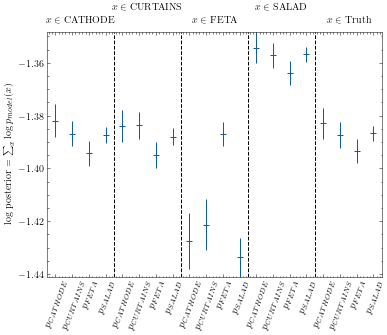

In [13]:
# plot average of the log posterior of the runs above

with open(f'log_posterior_{name_appendix}.npy', 'rb') as f:
    to_plot_central = np.load(f)
    to_plot_err = np.load(f)

ymin, ymax = np.min(to_plot_central-to_plot_err), np.max(to_plot_central+to_plot_err)

plt.figure(figsize=(6,4.5))

plt.errorbar(np.arange(20), to_plot_central, to_plot_err, fmt='_')
plt.vlines([3.5, 7.5, 11.5, 15.5], ymin, ymax, ls='dashed', color='k')
plt.ylim((ymin, ymax))
plt.xlim((-0.5, 19.5))
plt.ylabel('log posterior = $\sum_{x} \log{p_{model}(x)}$')
plt.gca().set_xticks(np.arange(20), *[5 * ['$p_{CATHODE}$', '$p_{CURTAINS}$', '$p_{FETA}$', '$p_{SALAD}$']], rotation=70)
plt.text(1.5, -1.345, '$x \in$ CATHODE', ha='center')
plt.text(5.5, -1.34, '$x \in$ CURTAINS', ha='center')
plt.text(9.5, -1.345, '$x \in$ FETA', ha='center')
plt.text(13.5, -1.34, '$x \in$ SALAD', ha='center')
plt.text(17.5, -1.345, '$x \in$ Truth', ha='center')
plt.show()

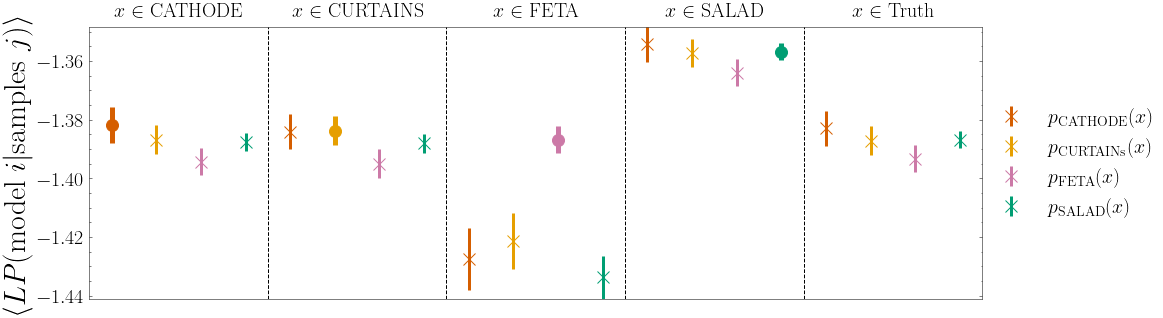

In [19]:
# plot average of the log posterior of the runs above, new layout by Radha

l = 3
f_1 = 20
f_2 = 30
alpha = 0.4
dpi = 800
ms = 12

with open(f'log_posterior_{name_appendix}.npy', 'rb') as f:
    to_plot_central = np.load(f)
    to_plot_err = np.load(f)

ymin, ymax = np.min(to_plot_central-to_plot_err), np.max(to_plot_central+to_plot_err)

order = ["cathode", "curtains", "feta", "salad"]


fig = plt.figure(figsize = (16, 5)) 

to_bold = [0, 5, 10, 15]
legends = ['$p_{\mathrm{CATHODE}}(x)$', '$p_{\mathrm{CURTAINs}}(x)$','$p_{\mathrm{FETA}}(x)$', '$p_{\mathrm{SALAD}}(x)$']
for i in range(20):
    
    if i in to_bold:
        plt.errorbar(i, to_plot_central[i], to_plot_err[i], fmt='o', color = colors_dict[order[i%4]],
                     elinewidth=5, markersize = ms )
    elif i >= 16:
        plt.errorbar(i, to_plot_central[i], to_plot_err[i], fmt='x', color = colors_dict[order[i%4]], 
                     elinewidth=3, markersize = ms, label = legends[i-16] )

    else:
        plt.errorbar(i, to_plot_central[i], to_plot_err[i], fmt='x', color = colors_dict[order[i%4]], 
                     elinewidth=3, markersize = ms)
    
plt.vlines([3.5, 7.5, 11.5, 15.5], ymin, ymax, ls='dashed', color='k')
plt.ylim((ymin, ymax))
plt.xlim((-0.5, 19.5))
plt.xticks([])
plt.yticks(fontsize = f_1)

plt.ylabel('$\sum_{x} \log{p_{model}(x)}$', fontsize = f_2)
plt.ylabel('$\\langle LP(\\text{model } i|\\text{samples } j) \\rangle$', fontsize = f_2)


plt.text(1.5, -1.345, '$x \in$ CATHODE', ha='center', fontsize = f_1)
plt.text(5.5, -1.345, '$x \in$ CURTAINS', ha='center', fontsize = f_1)
plt.text(9.5, -1.345, '$x \in$ FETA', ha='center', fontsize = f_1)
plt.text(13.5, -1.345, '$x \in$ SALAD', ha='center', fontsize = f_1)
plt.text(17.5, -1.345, '$x \in$ Truth', ha='center', fontsize = f_1)

plt.legend(fontsize = f_1, loc = "center", bbox_to_anchor=(1.1, 0.5))


fig.savefig(f"discrim_methods.pdf", dpi = dpi)

plt.show()




## modified NN
Uses a bigger NN than the rest of the draft

In [91]:
# build NN and optimizer, following https://github.com/rmastand/FETA/blob/ee4942e668b94df7b504b1503b027bdc28827eb1/helpers/evaluation.py#L209


dense_net = MyNeuralNet(input_shape=5)
dense_net.to(device)

print("model architecture ")
print(dense_net)
total_parameters = sum(p.numel() for p in dense_net.parameters() if p.requires_grad)
print(f"Model has {total_parameters:d} trainable parameters")

criterion = nn.NLLLoss(reduction='none')
optimizer = torch.optim.Adam(dense_net.parameters(), lr=1e-3)

model architecture 
MyNeuralNet(
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
  (dropout3): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=6, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=4, bias=True)
)
Model has 25924 trainable parameters


In [92]:
num_epoch = 400
name_appendix = 'run01_balanced_5_modified'

best_val_loss = 1e6

accuracy = []
_, acc = evaluate(dense_net, test_dataloader, criterion)
accuracy.append(acc.mean())

train_losses = []
eval_losses = []

for epoch in range(num_epoch):
    print(f"Epoch {epoch+1} / {num_epoch}")
    train_loss = train(dense_net, train_dataloader, optimizer, criterion)
    eval_loss, acc = evaluate(dense_net, test_dataloader, criterion)
    train_losses.append(train_loss.mean())
    eval_losses.append(eval_loss)
    accuracy.append(acc.mean())
    if eval_loss.mean() < best_val_loss:
        save_weights(dense_net, appendix=name_appendix)
        best_val_loss = eval_loss.mean()
    print("   - - - - -   ")

load_weights(dense_net, device, appendix=name_appendix)
_ = evaluate(dense_net, test_dataloader, criterion)

Evaluation loss 1.3822634987186806, accuracy 0.25, acc CATHODE: 1.000, acc CURTAINS: 0.000, acc FETA: 0.000, acc SALAD: 0.000
Epoch 1 / 400
step    0 / 480; loss 1.3778
step   40 / 480; loss 1.3757
step   80 / 480; loss 1.3803
step  120 / 480; loss 1.3800
step  160 / 480; loss 1.3738
step  200 / 480; loss 1.3747
step  240 / 480; loss 1.3733
step  280 / 480; loss 1.3830
step  320 / 480; loss 1.3877
step  360 / 480; loss 1.3772
step  400 / 480; loss 1.3768
step  440 / 480; loss 1.3798
Evaluation loss 1.3788914668362777, accuracy 0.250621875, acc CATHODE: 0.018, acc CURTAINS: 0.981, acc FETA: 0.004, acc SALAD: 0.000
Model saved
   - - - - -   
Epoch 2 / 400
step    0 / 480; loss 1.3792
step   40 / 480; loss 1.3824
step   80 / 480; loss 1.3808
step  120 / 480; loss 1.3835
step  160 / 480; loss 1.3790
step  200 / 480; loss 1.3718
step  240 / 480; loss 1.3870
step  280 / 480; loss 1.3764
step  320 / 480; loss 1.3724
step  360 / 480; loss 1.3784
step  400 / 480; loss 1.3860
step  440 / 480; l

step  400 / 480; loss 1.3756
step  440 / 480; loss 1.3868
Evaluation loss 1.3778339740545702, accuracy 0.257278125, acc CATHODE: 0.253, acc CURTAINS: 0.633, acc FETA: 0.143, acc SALAD: 0.000
   - - - - -   
Epoch 17 / 400
step    0 / 480; loss 1.3792
step   40 / 480; loss 1.3887
step   80 / 480; loss 1.3787
step  120 / 480; loss 1.3748
step  160 / 480; loss 1.3668
step  200 / 480; loss 1.3828
step  240 / 480; loss 1.3779
step  280 / 480; loss 1.3678
step  320 / 480; loss 1.3767
step  360 / 480; loss 1.3786
step  400 / 480; loss 1.3818
step  440 / 480; loss 1.3737
Evaluation loss 1.3778368385889792, accuracy 0.2568375, acc CATHODE: 0.175, acc CURTAINS: 0.466, acc FETA: 0.384, acc SALAD: 0.003
   - - - - -   
Epoch 18 / 400
step    0 / 480; loss 1.3747
step   40 / 480; loss 1.3750
step   80 / 480; loss 1.3786
step  120 / 480; loss 1.3710
step  160 / 480; loss 1.3718
step  200 / 480; loss 1.3795
step  240 / 480; loss 1.3752
step  280 / 480; loss 1.3758
step  320 / 480; loss 1.3772
step  3

step  320 / 480; loss 1.3790
step  360 / 480; loss 1.3822
step  400 / 480; loss 1.3772
step  440 / 480; loss 1.3855
Evaluation loss 1.3773227128894039, accuracy 0.25848125, acc CATHODE: 0.214, acc CURTAINS: 0.414, acc FETA: 0.385, acc SALAD: 0.021
   - - - - -   
Epoch 33 / 400
step    0 / 480; loss 1.3718
step   40 / 480; loss 1.3699
step   80 / 480; loss 1.3712
step  120 / 480; loss 1.3725
step  160 / 480; loss 1.3766
step  200 / 480; loss 1.3832
step  240 / 480; loss 1.3843
step  280 / 480; loss 1.3725
step  320 / 480; loss 1.3852
step  360 / 480; loss 1.3738
step  400 / 480; loss 1.3746
step  440 / 480; loss 1.3739
Evaluation loss 1.3772452011176108, accuracy 0.258921875, acc CATHODE: 0.188, acc CURTAINS: 0.390, acc FETA: 0.444, acc SALAD: 0.014
Model saved
   - - - - -   
Epoch 34 / 400
step    0 / 480; loss 1.3755
step   40 / 480; loss 1.3775
step   80 / 480; loss 1.3677
step  120 / 480; loss 1.3813
step  160 / 480; loss 1.3774
step  200 / 480; loss 1.3797
step  240 / 480; loss 1

step  240 / 480; loss 1.3749
step  280 / 480; loss 1.3743
step  320 / 480; loss 1.3716
step  360 / 480; loss 1.3702
step  400 / 480; loss 1.3776
step  440 / 480; loss 1.3722
Evaluation loss 1.3769896096598992, accuracy 0.260621875, acc CATHODE: 0.204, acc CURTAINS: 0.438, acc FETA: 0.353, acc SALAD: 0.047
Model saved
   - - - - -   
Epoch 49 / 400
step    0 / 480; loss 1.3793
step   40 / 480; loss 1.3766
step   80 / 480; loss 1.3717
step  120 / 480; loss 1.3800
step  160 / 480; loss 1.3735
step  200 / 480; loss 1.3717
step  240 / 480; loss 1.3848
step  280 / 480; loss 1.3772
step  320 / 480; loss 1.3775
step  360 / 480; loss 1.3707
step  400 / 480; loss 1.3817
step  440 / 480; loss 1.3756
Evaluation loss 1.3770005950054884, accuracy 0.261834375, acc CATHODE: 0.230, acc CURTAINS: 0.406, acc FETA: 0.359, acc SALAD: 0.053
   - - - - -   
Epoch 50 / 400
step    0 / 480; loss 1.3824
step   40 / 480; loss 1.3752
step   80 / 480; loss 1.3703
step  120 / 480; loss 1.3738
step  160 / 480; loss 

step  200 / 480; loss 1.3724
step  240 / 480; loss 1.3631
step  280 / 480; loss 1.3806
step  320 / 480; loss 1.3810
step  360 / 480; loss 1.3760
step  400 / 480; loss 1.3754
step  440 / 480; loss 1.3753
Evaluation loss 1.3768617626838944, accuracy 0.2620875, acc CATHODE: 0.158, acc CURTAINS: 0.412, acc FETA: 0.429, acc SALAD: 0.049
Model saved
   - - - - -   
Epoch 65 / 400
step    0 / 480; loss 1.3783
step   40 / 480; loss 1.3769
step   80 / 480; loss 1.3834
step  120 / 480; loss 1.3767
step  160 / 480; loss 1.3897
step  200 / 480; loss 1.3833
step  240 / 480; loss 1.3781
step  280 / 480; loss 1.3668
step  320 / 480; loss 1.3762
step  360 / 480; loss 1.3706
step  400 / 480; loss 1.3769
step  440 / 480; loss 1.3813
Evaluation loss 1.3769755933810894, accuracy 0.259634375, acc CATHODE: 0.244, acc CURTAINS: 0.481, acc FETA: 0.289, acc SALAD: 0.024
   - - - - -   
Epoch 66 / 400
step    0 / 480; loss 1.3693
step   40 / 480; loss 1.3734
step   80 / 480; loss 1.3784
step  120 / 480; loss 1.

step  160 / 480; loss 1.3762
step  200 / 480; loss 1.3824
step  240 / 480; loss 1.3720
step  280 / 480; loss 1.3794
step  320 / 480; loss 1.3778
step  360 / 480; loss 1.3639
step  400 / 480; loss 1.3809
step  440 / 480; loss 1.3698
Evaluation loss 1.376874020969473, accuracy 0.2621625, acc CATHODE: 0.255, acc CURTAINS: 0.316, acc FETA: 0.442, acc SALAD: 0.036
   - - - - -   
Epoch 81 / 400
step    0 / 480; loss 1.3709
step   40 / 480; loss 1.3759
step   80 / 480; loss 1.3798
step  120 / 480; loss 1.3779
step  160 / 480; loss 1.3758
step  200 / 480; loss 1.3803
step  240 / 480; loss 1.3782
step  280 / 480; loss 1.3910
step  320 / 480; loss 1.3784
step  360 / 480; loss 1.3812
step  400 / 480; loss 1.3769
step  440 / 480; loss 1.3661
Evaluation loss 1.3770022417054701, accuracy 0.26231875, acc CATHODE: 0.274, acc CURTAINS: 0.198, acc FETA: 0.485, acc SALAD: 0.092
   - - - - -   
Epoch 82 / 400
step    0 / 480; loss 1.3845
step   40 / 480; loss 1.3782
step   80 / 480; loss 1.3724
step  120

step  200 / 480; loss 1.3795
step  240 / 480; loss 1.3869
step  280 / 480; loss 1.3767
step  320 / 480; loss 1.3762
step  360 / 480; loss 1.3774
step  400 / 480; loss 1.3830
step  440 / 480; loss 1.3803
Evaluation loss 1.376820178050894, accuracy 0.26278125, acc CATHODE: 0.162, acc CURTAINS: 0.369, acc FETA: 0.399, acc SALAD: 0.121
   - - - - -   
Epoch 97 / 400
step    0 / 480; loss 1.3712
step   40 / 480; loss 1.3793
step   80 / 480; loss 1.3815
step  120 / 480; loss 1.3709
step  160 / 480; loss 1.3692
step  200 / 480; loss 1.3867
step  240 / 480; loss 1.3740
step  280 / 480; loss 1.3738
step  320 / 480; loss 1.3707
step  360 / 480; loss 1.3740
step  400 / 480; loss 1.3753
step  440 / 480; loss 1.3745
Evaluation loss 1.376879197433599, accuracy 0.264209375, acc CATHODE: 0.166, acc CURTAINS: 0.409, acc FETA: 0.333, acc SALAD: 0.148
   - - - - -   
Epoch 98 / 400
step    0 / 480; loss 1.3745
step   40 / 480; loss 1.3698
step   80 / 480; loss 1.3661
step  120 / 480; loss 1.3674
step  16

step  200 / 480; loss 1.3716
step  240 / 480; loss 1.3690
step  280 / 480; loss 1.3850
step  320 / 480; loss 1.3772
step  360 / 480; loss 1.3808
step  400 / 480; loss 1.3761
step  440 / 480; loss 1.3782
Evaluation loss 1.376731260319813, accuracy 0.263759375, acc CATHODE: 0.238, acc CURTAINS: 0.319, acc FETA: 0.415, acc SALAD: 0.082
   - - - - -   
Epoch 113 / 400
step    0 / 480; loss 1.3707
step   40 / 480; loss 1.3793
step   80 / 480; loss 1.3684
step  120 / 480; loss 1.3789
step  160 / 480; loss 1.3719
step  200 / 480; loss 1.3709
step  240 / 480; loss 1.3732
step  280 / 480; loss 1.3775
step  320 / 480; loss 1.3692
step  360 / 480; loss 1.3810
step  400 / 480; loss 1.3754
step  440 / 480; loss 1.3614
Evaluation loss 1.3768278310661743, accuracy 0.263975, acc CATHODE: 0.183, acc CURTAINS: 0.328, acc FETA: 0.399, acc SALAD: 0.146
   - - - - -   
Epoch 114 / 400
step    0 / 480; loss 1.3780
step   40 / 480; loss 1.3788
step   80 / 480; loss 1.3819
step  120 / 480; loss 1.3785
step  1

step  240 / 480; loss 1.3781
step  280 / 480; loss 1.3766
step  320 / 480; loss 1.3766
step  360 / 480; loss 1.3703
step  400 / 480; loss 1.3767
step  440 / 480; loss 1.3762
Evaluation loss 1.3768971562087922, accuracy 0.263578125, acc CATHODE: 0.150, acc CURTAINS: 0.367, acc FETA: 0.474, acc SALAD: 0.064
   - - - - -   
Epoch 129 / 400
step    0 / 480; loss 1.3736
step   40 / 480; loss 1.3785
step   80 / 480; loss 1.3764
step  120 / 480; loss 1.3762
step  160 / 480; loss 1.3683
step  200 / 480; loss 1.3705
step  240 / 480; loss 1.3732
step  280 / 480; loss 1.3756
step  320 / 480; loss 1.3738
step  360 / 480; loss 1.3788
step  400 / 480; loss 1.3778
step  440 / 480; loss 1.3743
Evaluation loss 1.376929657120884, accuracy 0.26295625, acc CATHODE: 0.274, acc CURTAINS: 0.264, acc FETA: 0.431, acc SALAD: 0.084
   - - - - -   
Epoch 130 / 400
step    0 / 480; loss 1.3783
step   40 / 480; loss 1.3757
step   80 / 480; loss 1.3736
step  120 / 480; loss 1.3763
step  160 / 480; loss 1.3868
step 

step  240 / 480; loss 1.3777
step  280 / 480; loss 1.3744
step  320 / 480; loss 1.3765
step  360 / 480; loss 1.3733
step  400 / 480; loss 1.3778
step  440 / 480; loss 1.3793
Evaluation loss 1.3768994206785656, accuracy 0.264109375, acc CATHODE: 0.206, acc CURTAINS: 0.346, acc FETA: 0.376, acc SALAD: 0.128
   - - - - -   
Epoch 145 / 400
step    0 / 480; loss 1.3745
step   40 / 480; loss 1.3731
step   80 / 480; loss 1.3632
step  120 / 480; loss 1.3727
step  160 / 480; loss 1.3764
step  200 / 480; loss 1.3728
step  240 / 480; loss 1.3726
step  280 / 480; loss 1.3696
step  320 / 480; loss 1.3674
step  360 / 480; loss 1.3858
step  400 / 480; loss 1.3792
step  440 / 480; loss 1.3799
Evaluation loss 1.3770910720255731, accuracy 0.262628125, acc CATHODE: 0.246, acc CURTAINS: 0.341, acc FETA: 0.342, acc SALAD: 0.122
   - - - - -   
Epoch 146 / 400
step    0 / 480; loss 1.3698
step   40 / 480; loss 1.3642
step   80 / 480; loss 1.3629
step  120 / 480; loss 1.3777
step  160 / 480; loss 1.3693
ste

step  280 / 480; loss 1.3743
step  320 / 480; loss 1.3676
step  360 / 480; loss 1.3755
step  400 / 480; loss 1.3742
step  440 / 480; loss 1.3720
Evaluation loss 1.3769237894361845, accuracy 0.2637875, acc CATHODE: 0.223, acc CURTAINS: 0.325, acc FETA: 0.404, acc SALAD: 0.103
   - - - - -   
Epoch 161 / 400
step    0 / 480; loss 1.3720
step   40 / 480; loss 1.3763
step   80 / 480; loss 1.3783
step  120 / 480; loss 1.3822
step  160 / 480; loss 1.3727
step  200 / 480; loss 1.3712
step  240 / 480; loss 1.3764
step  280 / 480; loss 1.3747
step  320 / 480; loss 1.3744
step  360 / 480; loss 1.3696
step  400 / 480; loss 1.3743
step  440 / 480; loss 1.3679
Evaluation loss 1.3769767418676477, accuracy 0.26401875, acc CATHODE: 0.203, acc CURTAINS: 0.363, acc FETA: 0.378, acc SALAD: 0.112
   - - - - -   
Epoch 162 / 400
step    0 / 480; loss 1.3802
step   40 / 480; loss 1.3708
step   80 / 480; loss 1.3794
step  120 / 480; loss 1.3677
step  160 / 480; loss 1.3791
step  200 / 480; loss 1.3678
step  

step  280 / 480; loss 1.3822
step  320 / 480; loss 1.3817
step  360 / 480; loss 1.3664
step  400 / 480; loss 1.3784
step  440 / 480; loss 1.3775
Evaluation loss 1.3769275555969744, accuracy 0.2627, acc CATHODE: 0.240, acc CURTAINS: 0.315, acc FETA: 0.396, acc SALAD: 0.100
   - - - - -   
Epoch 177 / 400
step    0 / 480; loss 1.3666
step   40 / 480; loss 1.3724
step   80 / 480; loss 1.3762
step  120 / 480; loss 1.3751
step  160 / 480; loss 1.3681
step  200 / 480; loss 1.3748
step  240 / 480; loss 1.3775
step  280 / 480; loss 1.3846
step  320 / 480; loss 1.3685
step  360 / 480; loss 1.3809
step  400 / 480; loss 1.3807
step  440 / 480; loss 1.3779
Evaluation loss 1.3771456802620903, accuracy 0.263065625, acc CATHODE: 0.213, acc CURTAINS: 0.374, acc FETA: 0.393, acc SALAD: 0.073
   - - - - -   
Epoch 178 / 400
step    0 / 480; loss 1.3772
step   40 / 480; loss 1.3768
step   80 / 480; loss 1.3712
step  120 / 480; loss 1.3760
step  160 / 480; loss 1.3790
step  200 / 480; loss 1.3734
step  24

step  320 / 480; loss 1.3659
step  360 / 480; loss 1.3725
step  400 / 480; loss 1.3742
step  440 / 480; loss 1.3685
Evaluation loss 1.3770131215133572, accuracy 0.2629625, acc CATHODE: 0.131, acc CURTAINS: 0.438, acc FETA: 0.382, acc SALAD: 0.101
   - - - - -   
Epoch 193 / 400
step    0 / 480; loss 1.3742
step   40 / 480; loss 1.3745
step   80 / 480; loss 1.3782
step  120 / 480; loss 1.3706
step  160 / 480; loss 1.3785
step  200 / 480; loss 1.3715
step  240 / 480; loss 1.3765
step  280 / 480; loss 1.3694
step  320 / 480; loss 1.3764
step  360 / 480; loss 1.3685
step  400 / 480; loss 1.3734
step  440 / 480; loss 1.3697
Evaluation loss 1.3770597705853118, accuracy 0.263665625, acc CATHODE: 0.206, acc CURTAINS: 0.299, acc FETA: 0.417, acc SALAD: 0.133
   - - - - -   
Epoch 194 / 400
step    0 / 480; loss 1.3714
step   40 / 480; loss 1.3758
step   80 / 480; loss 1.3750
step  120 / 480; loss 1.3817
step  160 / 480; loss 1.3777
step  200 / 480; loss 1.3808
step  240 / 480; loss 1.3824
step 

step  360 / 480; loss 1.3658
step  400 / 480; loss 1.3753
step  440 / 480; loss 1.3788
Evaluation loss 1.3770088966259, accuracy 0.2621375, acc CATHODE: 0.207, acc CURTAINS: 0.413, acc FETA: 0.277, acc SALAD: 0.152
   - - - - -   
Epoch 209 / 400
step    0 / 480; loss 1.3755
step   40 / 480; loss 1.3717
step   80 / 480; loss 1.3864
step  120 / 480; loss 1.3806
step  160 / 480; loss 1.3723
step  200 / 480; loss 1.3789
step  240 / 480; loss 1.3635
step  280 / 480; loss 1.3857
step  320 / 480; loss 1.3726
step  360 / 480; loss 1.3684
step  400 / 480; loss 1.3756
step  440 / 480; loss 1.3766
Evaluation loss 1.3769454084270716, accuracy 0.26221875, acc CATHODE: 0.190, acc CURTAINS: 0.326, acc FETA: 0.446, acc SALAD: 0.087
   - - - - -   
Epoch 210 / 400
step    0 / 480; loss 1.3784
step   40 / 480; loss 1.3735
step   80 / 480; loss 1.3727
step  120 / 480; loss 1.3809
step  160 / 480; loss 1.3794
step  200 / 480; loss 1.3705
step  240 / 480; loss 1.3636
step  280 / 480; loss 1.3734
step  320

step  400 / 480; loss 1.3676
step  440 / 480; loss 1.3644
Evaluation loss 1.377128415216245, accuracy 0.262884375, acc CATHODE: 0.218, acc CURTAINS: 0.398, acc FETA: 0.355, acc SALAD: 0.081
   - - - - -   
Epoch 225 / 400
step    0 / 480; loss 1.3754
step   40 / 480; loss 1.3725
step   80 / 480; loss 1.3658
step  120 / 480; loss 1.3776
step  160 / 480; loss 1.3835
step  200 / 480; loss 1.3708
step  240 / 480; loss 1.3705
step  280 / 480; loss 1.3731
step  320 / 480; loss 1.3756
step  360 / 480; loss 1.3756
step  400 / 480; loss 1.3815
step  440 / 480; loss 1.3644
Evaluation loss 1.37700321136102, accuracy 0.2637875, acc CATHODE: 0.299, acc CURTAINS: 0.301, acc FETA: 0.368, acc SALAD: 0.087
   - - - - -   
Epoch 226 / 400
step    0 / 480; loss 1.3756
step   40 / 480; loss 1.3729
step   80 / 480; loss 1.3663
step  120 / 480; loss 1.3739
step  160 / 480; loss 1.3783
step  200 / 480; loss 1.3664
step  240 / 480; loss 1.3743
step  280 / 480; loss 1.3803
step  320 / 480; loss 1.3721
step  36

step  440 / 480; loss 1.3785
Evaluation loss 1.3771525402467204, accuracy 0.262428125, acc CATHODE: 0.317, acc CURTAINS: 0.277, acc FETA: 0.355, acc SALAD: 0.101
   - - - - -   
Epoch 241 / 400
step    0 / 480; loss 1.3774
step   40 / 480; loss 1.3776
step   80 / 480; loss 1.3795
step  120 / 480; loss 1.3721
step  160 / 480; loss 1.3779
step  200 / 480; loss 1.3774
step  240 / 480; loss 1.3724
step  280 / 480; loss 1.3804
step  320 / 480; loss 1.3599
step  360 / 480; loss 1.3718
step  400 / 480; loss 1.3615
step  440 / 480; loss 1.3823
Evaluation loss 1.3771141036280772, accuracy 0.26356875, acc CATHODE: 0.144, acc CURTAINS: 0.308, acc FETA: 0.496, acc SALAD: 0.107
   - - - - -   
Epoch 242 / 400
step    0 / 480; loss 1.3752
step   40 / 480; loss 1.3694
step   80 / 480; loss 1.3677
step  120 / 480; loss 1.3688
step  160 / 480; loss 1.3823
step  200 / 480; loss 1.3642
step  240 / 480; loss 1.3798
step  280 / 480; loss 1.3704
step  320 / 480; loss 1.3729
step  360 / 480; loss 1.3813
step

step  440 / 480; loss 1.3793
Evaluation loss 1.3771430492205614, accuracy 0.262884375, acc CATHODE: 0.286, acc CURTAINS: 0.355, acc FETA: 0.318, acc SALAD: 0.092
   - - - - -   
Epoch 257 / 400
step    0 / 480; loss 1.3734
step   40 / 480; loss 1.3822
step   80 / 480; loss 1.3810
step  120 / 480; loss 1.3707
step  160 / 480; loss 1.3843
step  200 / 480; loss 1.3750
step  240 / 480; loss 1.3781
step  280 / 480; loss 1.3802
step  320 / 480; loss 1.3699
step  360 / 480; loss 1.3866
step  400 / 480; loss 1.3772
step  440 / 480; loss 1.3674
Evaluation loss 1.3770868054491074, accuracy 0.2624875, acc CATHODE: 0.274, acc CURTAINS: 0.350, acc FETA: 0.315, acc SALAD: 0.112
   - - - - -   
Epoch 258 / 400
step    0 / 480; loss 1.3689
step   40 / 480; loss 1.3819
step   80 / 480; loss 1.3742
step  120 / 480; loss 1.3709
step  160 / 480; loss 1.3710
step  200 / 480; loss 1.3653
step  240 / 480; loss 1.3774
step  280 / 480; loss 1.3766
step  320 / 480; loss 1.3750
step  360 / 480; loss 1.3796
step 

Evaluation loss 1.377159757584154, accuracy 0.262034375, acc CATHODE: 0.223, acc CURTAINS: 0.389, acc FETA: 0.346, acc SALAD: 0.090
   - - - - -   
Epoch 273 / 400
step    0 / 480; loss 1.3751
step   40 / 480; loss 1.3855
step   80 / 480; loss 1.3743
step  120 / 480; loss 1.3783
step  160 / 480; loss 1.3746
step  200 / 480; loss 1.3745
step  240 / 480; loss 1.3821
step  280 / 480; loss 1.3700
step  320 / 480; loss 1.3742
step  360 / 480; loss 1.3770
step  400 / 480; loss 1.3780
step  440 / 480; loss 1.3661
Evaluation loss 1.3771491791451957, accuracy 0.26224375, acc CATHODE: 0.290, acc CURTAINS: 0.297, acc FETA: 0.371, acc SALAD: 0.091
   - - - - -   
Epoch 274 / 400
step    0 / 480; loss 1.3640
step   40 / 480; loss 1.3840
step   80 / 480; loss 1.3814
step  120 / 480; loss 1.3778
step  160 / 480; loss 1.3673
step  200 / 480; loss 1.3758
step  240 / 480; loss 1.3797
step  280 / 480; loss 1.3759
step  320 / 480; loss 1.3698
step  360 / 480; loss 1.3702
step  400 / 480; loss 1.3799
step 

step   40 / 480; loss 1.3724
step   80 / 480; loss 1.3756
step  120 / 480; loss 1.3701
step  160 / 480; loss 1.3790
step  200 / 480; loss 1.3810
step  240 / 480; loss 1.3746
step  280 / 480; loss 1.3823
step  320 / 480; loss 1.3749
step  360 / 480; loss 1.3754
step  400 / 480; loss 1.3869
step  440 / 480; loss 1.3760
Evaluation loss 1.377324633072082, accuracy 0.262609375, acc CATHODE: 0.182, acc CURTAINS: 0.344, acc FETA: 0.390, acc SALAD: 0.135
   - - - - -   
Epoch 290 / 400
step    0 / 480; loss 1.3656
step   40 / 480; loss 1.3752
step   80 / 480; loss 1.3825
step  120 / 480; loss 1.3674
step  160 / 480; loss 1.3786
step  200 / 480; loss 1.3713
step  240 / 480; loss 1.3658
step  280 / 480; loss 1.3753
step  320 / 480; loss 1.3845
step  360 / 480; loss 1.3788
step  400 / 480; loss 1.3644
step  440 / 480; loss 1.3805
Evaluation loss 1.3773265503315848, accuracy 0.262978125, acc CATHODE: 0.207, acc CURTAINS: 0.351, acc FETA: 0.432, acc SALAD: 0.062
   - - - - -   
Epoch 291 / 400
step

step   80 / 480; loss 1.3782
step  120 / 480; loss 1.3715
step  160 / 480; loss 1.3771
step  200 / 480; loss 1.3615
step  240 / 480; loss 1.3829
step  280 / 480; loss 1.3687
step  320 / 480; loss 1.3659
step  360 / 480; loss 1.3712
step  400 / 480; loss 1.3785
step  440 / 480; loss 1.3789
Evaluation loss 1.3772594380556888, accuracy 0.26329375, acc CATHODE: 0.235, acc CURTAINS: 0.339, acc FETA: 0.381, acc SALAD: 0.099
   - - - - -   
Epoch 306 / 400
step    0 / 480; loss 1.3761
step   40 / 480; loss 1.3717
step   80 / 480; loss 1.3747
step  120 / 480; loss 1.3668
step  160 / 480; loss 1.3742
step  200 / 480; loss 1.3687
step  240 / 480; loss 1.3801
step  280 / 480; loss 1.3732
step  320 / 480; loss 1.3841
step  360 / 480; loss 1.3680
step  400 / 480; loss 1.3748
step  440 / 480; loss 1.3653
Evaluation loss 1.37733975228154, accuracy 0.263725, acc CATHODE: 0.257, acc CURTAINS: 0.345, acc FETA: 0.322, acc SALAD: 0.131
   - - - - -   
Epoch 307 / 400
step    0 / 480; loss 1.3731
step   40

step  120 / 480; loss 1.3869
step  160 / 480; loss 1.3739
step  200 / 480; loss 1.3692
step  240 / 480; loss 1.3735
step  280 / 480; loss 1.3665
step  320 / 480; loss 1.3799
step  360 / 480; loss 1.3846
step  400 / 480; loss 1.3698
step  440 / 480; loss 1.3693
Evaluation loss 1.3773413274342954, accuracy 0.263146875, acc CATHODE: 0.258, acc CURTAINS: 0.332, acc FETA: 0.370, acc SALAD: 0.092
   - - - - -   
Epoch 322 / 400
step    0 / 480; loss 1.3723
step   40 / 480; loss 1.3850
step   80 / 480; loss 1.3789
step  120 / 480; loss 1.3738
step  160 / 480; loss 1.3796
step  200 / 480; loss 1.3831
step  240 / 480; loss 1.3852
step  280 / 480; loss 1.3767
step  320 / 480; loss 1.3796
step  360 / 480; loss 1.3683
step  400 / 480; loss 1.3865
step  440 / 480; loss 1.3817
Evaluation loss 1.3771655026002338, accuracy 0.263775, acc CATHODE: 0.191, acc CURTAINS: 0.450, acc FETA: 0.313, acc SALAD: 0.102
   - - - - -   
Epoch 323 / 400
step    0 / 480; loss 1.3754
step   40 / 480; loss 1.3869
step  

step  160 / 480; loss 1.3679
step  200 / 480; loss 1.3813
step  240 / 480; loss 1.3845
step  280 / 480; loss 1.3756
step  320 / 480; loss 1.3771
step  360 / 480; loss 1.3656
step  400 / 480; loss 1.3715
step  440 / 480; loss 1.3688
Evaluation loss 1.377394619236194, accuracy 0.264346875, acc CATHODE: 0.211, acc CURTAINS: 0.380, acc FETA: 0.364, acc SALAD: 0.103
   - - - - -   
Epoch 338 / 400
step    0 / 480; loss 1.3722
step   40 / 480; loss 1.3787
step   80 / 480; loss 1.3802
step  120 / 480; loss 1.3744
step  160 / 480; loss 1.3764
step  200 / 480; loss 1.3618
step  240 / 480; loss 1.3756
step  280 / 480; loss 1.3760
step  320 / 480; loss 1.3665
step  360 / 480; loss 1.3719
step  400 / 480; loss 1.3735
step  440 / 480; loss 1.3660
Evaluation loss 1.3773136700408046, accuracy 0.262803125, acc CATHODE: 0.194, acc CURTAINS: 0.350, acc FETA: 0.427, acc SALAD: 0.080
   - - - - -   
Epoch 339 / 400
step    0 / 480; loss 1.3742
step   40 / 480; loss 1.3646
step   80 / 480; loss 1.3735
step

step  200 / 480; loss 1.3761
step  240 / 480; loss 1.3703
step  280 / 480; loss 1.3707
step  320 / 480; loss 1.3694
step  360 / 480; loss 1.3834
step  400 / 480; loss 1.3770
step  440 / 480; loss 1.3628
Evaluation loss 1.3773450040875839, accuracy 0.261196875, acc CATHODE: 0.230, acc CURTAINS: 0.300, acc FETA: 0.457, acc SALAD: 0.058
   - - - - -   
Epoch 354 / 400
step    0 / 480; loss 1.3780
step   40 / 480; loss 1.3836
step   80 / 480; loss 1.3675
step  120 / 480; loss 1.3754
step  160 / 480; loss 1.3740
step  200 / 480; loss 1.3688
step  240 / 480; loss 1.3819
step  280 / 480; loss 1.3681
step  320 / 480; loss 1.3722
step  360 / 480; loss 1.3689
step  400 / 480; loss 1.3661
step  440 / 480; loss 1.3686
Evaluation loss 1.3771964843344637, accuracy 0.263509375, acc CATHODE: 0.186, acc CURTAINS: 0.408, acc FETA: 0.354, acc SALAD: 0.106
   - - - - -   
Epoch 355 / 400
step    0 / 480; loss 1.3752
step   40 / 480; loss 1.3745
step   80 / 480; loss 1.3666
step  120 / 480; loss 1.3696
ste

step  200 / 480; loss 1.3650
step  240 / 480; loss 1.3703
step  280 / 480; loss 1.3729
step  320 / 480; loss 1.3662
step  360 / 480; loss 1.3727
step  400 / 480; loss 1.3766
step  440 / 480; loss 1.3667
Evaluation loss 1.377265199975986, accuracy 0.2633625, acc CATHODE: 0.271, acc CURTAINS: 0.312, acc FETA: 0.384, acc SALAD: 0.086
   - - - - -   
Epoch 370 / 400
step    0 / 480; loss 1.3792
step   40 / 480; loss 1.3808
step   80 / 480; loss 1.3692
step  120 / 480; loss 1.3759
step  160 / 480; loss 1.3783
step  200 / 480; loss 1.3862
step  240 / 480; loss 1.3659
step  280 / 480; loss 1.3733
step  320 / 480; loss 1.3837
step  360 / 480; loss 1.3907
step  400 / 480; loss 1.3764
step  440 / 480; loss 1.3712
Evaluation loss 1.3772327784225904, accuracy 0.26350625, acc CATHODE: 0.244, acc CURTAINS: 0.308, acc FETA: 0.352, acc SALAD: 0.150
   - - - - -   
Epoch 371 / 400
step    0 / 480; loss 1.3741
step   40 / 480; loss 1.3808
step   80 / 480; loss 1.3737
step  120 / 480; loss 1.3757
step  1

step  240 / 480; loss 1.3676
step  280 / 480; loss 1.3776
step  320 / 480; loss 1.3704
step  360 / 480; loss 1.3734
step  400 / 480; loss 1.3773
step  440 / 480; loss 1.3759
Evaluation loss 1.3772058294718812, accuracy 0.2631875, acc CATHODE: 0.229, acc CURTAINS: 0.345, acc FETA: 0.369, acc SALAD: 0.109
   - - - - -   
Epoch 386 / 400
step    0 / 480; loss 1.3752
step   40 / 480; loss 1.3704
step   80 / 480; loss 1.3753
step  120 / 480; loss 1.3758
step  160 / 480; loss 1.3691
step  200 / 480; loss 1.3687
step  240 / 480; loss 1.3691
step  280 / 480; loss 1.3683
step  320 / 480; loss 1.3703
step  360 / 480; loss 1.3818
step  400 / 480; loss 1.3695
step  440 / 480; loss 1.3673
Evaluation loss 1.3774822568357157, accuracy 0.26211875, acc CATHODE: 0.212, acc CURTAINS: 0.317, acc FETA: 0.420, acc SALAD: 0.099
   - - - - -   
Epoch 387 / 400
step    0 / 480; loss 1.3785
step   40 / 480; loss 1.3642
step   80 / 480; loss 1.3786
step  120 / 480; loss 1.3709
step  160 / 480; loss 1.3785
step  

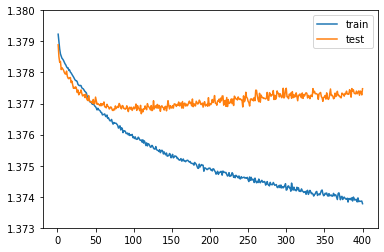

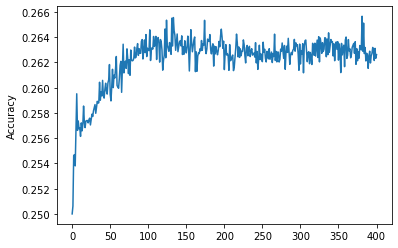

In [93]:
epochs = np.arange(num_epoch) + 1
plt.plot(epochs, train_losses, label='train')
plt.plot(epochs, eval_losses, label='test')
plt.legend()
plt.ylim(1.373, 1.38)
plt.show()

plt.plot(accuracy)
plt.ylabel("Accuracy")
plt.show()

In [13]:
# run multiple runs at once

output_str = "log posterior of {} is {}. Argmax is at {}"
output_str_2 = "log posterior of {} is {} +/- {}. Argmax is at {}"

preds_cathode_list = []
preds_curtains_list = []
preds_feta_list = []
preds_salad_list = []
weights_salad_list = []
preds_truth_list = []

log_posterior_dict = {'CATHODE': [], 'CURTAINS': [], 'FETA': [], 'SALAD': [], 'TRUTH': []}

for run_nr in [1,2,3,4,5, 6, 7, 8, 9, 10]:
    print(f"Run nr {run_nr}")
    name_appendix = f'run{run_nr:02d}_balanced_5_modified'
    load_weights(dense_net, device, appendix=name_appendix)
    preds_models, weights_models = get_prediction(dense_net, test_dataloader)
    preds_truth, _ = get_prediction(dense_net, truth_dataloader)
    preds_cathode_list.append(preds_models[preds_models[:, -1] == 0.][:, :4])
    preds_curtains_list.append(preds_models[preds_models[:, -1] == 1.][:, :4])
    preds_feta_list.append(preds_models[preds_models[:, -1] == 2.][:, :4])
    preds_salad_list.append(preds_models[preds_models[:, -1] == 3.][:, :4])
    weights_salad_list.append(weights_models[preds_models[:, -1] == 3.].reshape(-1,1))
    preds_truth_list.append(preds_truth[:, :4])
    
    print(output_str.format("CATHODE samples", 
                            post_local:=log_posterior(preds_cathode_list[-1]), 
                            np.argmax(log_posterior(preds_cathode_list[-1]))))
    log_posterior_dict['CATHODE'].append(post_local/len(preds_cathode_list[-1]))
    print(output_str.format("CURTAINS samples", 
                            post_local:=log_posterior(preds_curtains_list[-1]), 
                            np.argmax(log_posterior(preds_curtains_list[-1]))))
    log_posterior_dict['CURTAINS'].append(post_local/len(preds_curtains_list[-1]))
    print(output_str.format("FETA samples", 
                            post_local:=log_posterior(preds_feta_list[-1]), 
                            np.argmax(log_posterior(preds_feta_list[-1]))))
    log_posterior_dict['FETA'].append(post_local/len(preds_feta_list[-1]))
    print(output_str.format("SALAD samples", 
                            post_local:=log_posterior(preds_salad_list[-1], weights=weights_salad_list[-1]), 
                            np.argmax(log_posterior(preds_salad_list[-1]))))
    #log_posterior_dict['SALAD'].append(post_local/(weights_salad_list[-1].sum()))
    log_posterior_dict['SALAD'].append(post_local/len(preds_salad_list[-1]))
    print(output_str.format("True samples", 
                            post_local:=log_posterior(preds_truth_list[-1]), 
                            np.argmax(log_posterior(preds_truth_list[-1]))))
    log_posterior_dict['TRUTH'].append(post_local/len(preds_truth_list[-1]))
    
preds_cathode_list = np.array(preds_cathode_list)
preds_curtains_list = np.array(preds_curtains_list)
preds_feta_list = np.array(preds_feta_list)
preds_salad_list = np.array(preds_salad_list)
weights_salad_list = np.array(weights_salad_list)
preds_truth_list = np.array(preds_truth_list)

for key in log_posterior_dict:
    log_posterior_dict[key] = np.array(log_posterior_dict[key])

print("averaged scores: ")
print(output_str.format("CATHODE samples", 
                        log_posterior(preds_cathode_list.mean(0)),
                        np.argmax(log_posterior(preds_cathode_list.mean(0)))))
print(output_str.format("CURTAINS samples", 
                        log_posterior(preds_curtains_list.mean(0)), 
                        np.argmax(log_posterior(preds_curtains_list.mean(0)))))
print(output_str.format("FETA samples", 
                        log_posterior(preds_feta_list.mean(0)), 
                        np.argmax(log_posterior(preds_feta_list.mean(0)))))
print(output_str.format("SALAD samples", 
                        log_posterior(preds_salad_list.mean(0)), 
                        np.argmax(log_posterior(preds_salad_list.mean(0)))))
print(output_str.format("True samples", 
                        log_posterior(preds_truth_list.mean(0)), 
                        np.argmax(log_posterior(preds_truth_list.mean(0)))))
print("Mean and std of individual runs: ")

to_plot_central = []
to_plot_err = []

for method in ['CATHODE', 'CURTAINS', 'FETA', 'SALAD', 'TRUTH']:
    print(f"Based on {len(log_posterior_dict[method])} runs.")
    print(output_str_2.format(f"{method} samples", 
                              cen:=log_posterior_dict[method].mean(0),
                              err:=log_posterior_dict[method].std(0),
                              np.argmax(log_posterior_dict[method].mean(0))))
    to_plot_central.append(cen)
    to_plot_err.append(err)
to_plot_central = np.array(to_plot_central).flatten()
to_plot_err = np.array(to_plot_err).flatten()

with open('log_posterior_mod.npy', 'wb') as f:
    np.save(f, to_plot_central)
    np.save(f, to_plot_err)
with open('log_posterior_mod.npy', 'rb') as f:
    to_plot_central = np.load(f)
    to_plot_err = np.load(f)

Run nr 1


RuntimeError: Error(s) in loading state_dict for NeuralNet:
	Unexpected key(s) in state_dict: "fc4.weight", "fc4.bias". 
	size mismatch for fc1.weight: copying a param with shape torch.Size([128, 6]) from checkpoint, the shape in current model is torch.Size([64, 6]).
	size mismatch for fc1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for fc2.weight: copying a param with shape torch.Size([128, 128]) from checkpoint, the shape in current model is torch.Size([32, 64]).
	size mismatch for fc2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fc3.weight: copying a param with shape torch.Size([64, 128]) from checkpoint, the shape in current model is torch.Size([4, 32]).
	size mismatch for fc3.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([4]).

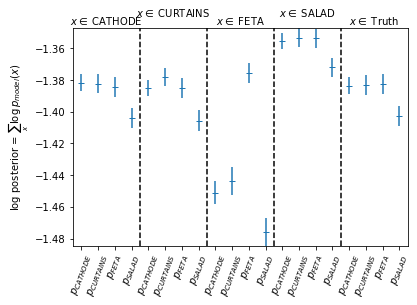

In [105]:
# plot average of the log posterior of the runs above
ymin, ymax = np.min(to_plot_central-to_plot_err), np.max(to_plot_central+to_plot_err)

plt.errorbar(np.arange(20), to_plot_central, to_plot_err, fmt='_')
plt.vlines([3.5, 7.5, 11.5, 15.5], ymin, ymax, ls='dashed', color='k')
plt.ylim((ymin, ymax))
plt.xlim((-0.5, 19.5))
plt.ylabel('log posterior = $\sum_{x} \log{p_{model}(x)}$')
plt.gca().set_xticks(np.arange(20), *[5 * ['$p_{CATHODE}$', '$p_{CURTAINS}$', '$p_{FETA}$', '$p_{SALAD}$']], rotation=70)
plt.text(1.5, -1.345, '$x \in$ CATHODE', ha='center')
plt.text(5.5, -1.34, '$x \in$ CURTAINS', ha='center')
plt.text(9.5, -1.345, '$x \in$ FETA', ha='center')
plt.text(13.5, -1.34, '$x \in$ SALAD', ha='center')
plt.text(17.5, -1.345, '$x \in$ Truth', ha='center')
plt.show()